In [1]:
#modified from Ang et al.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
OLIGO_TABLE_PATH = '../data_tables/oligos_nonuniq_crispey3_GG_9bp_OLIGO_with_seq_primers.txt'
lova = pd.read_csv('../data_tables/Deseq_outputs/deseq2_res_bar_P1_LOV_competitiontime_SCM_umi_level.tsv', sep = '\t')
nacl = pd.read_csv('../data_tables/Deseq_outputs/deseq2_res_bar_P1_NACL_competitiontime_SCM_umi_level.tsv', sep = '\t')
caff = pd.read_csv('../data_tables/Deseq_outputs/deseq2_res_bar_P1_CAFF_competitiontime_SCM_umi_level.tsv', sep = '\t')
sc = pd.read_csv('../data_tables/Deseq_outputs/deseq2_res_bar_P1_SCM_competitiontime_SCM_umi_level.tsv', sep = '\t')
cocl = pd.read_csv('../data_tables/Deseq_outputs/deseq2_res_bar_P1_COCL_competitiontime_SCM_umi_level.tsv', sep = '\t')
tbf = pd.read_csv('../data_tables/Deseq_outputs/deseq2_res_bar_P1_TBF_competitiontime_SCM_umi_level.tsv',sep = '\t')




In [3]:
def romanToInt(s):
      """
      :type s: str
      :rtype: int
      """
      roman = {'I':1,'V':5,'X':10,'L':50,'C':100,'D':500,'M':1000,'IV':4,'IX':9,'XL':40,'XC':90,'CD':400,'CM':900}
      i = 0
      num = 0
      try:
          while i < len(s):
             if i+1<len(s) and s[i:i+2] in roman:
                num+=roman[s[i:i+2]]
                i+=2
             else:
                #print(i)
                num+=roman[s[i]]
                i+=1
          return num
      except:
        return s
      

In [4]:
oli_info = pd.read_csv(OLIGO_TABLE_PATH,'\t')
lova['barcode_id'] =lova.index.str.split('_').str[1:3].str.join('_')
nacl['barcode_id'] =nacl.index.str.split('_').str[1:3].str.join('_')
caff['barcode_id'] =caff.index.str.split('_').str[1:3].str.join('_')
sc['barcode_id'] =sc.index.str.split('_').str[1:3].str.join('_')
cocl['barcode_id'] =cocl.index.str.split('_').str[1:3].str.join('_')
tbf['barcode_id'] =tbf.index.str.split('_').str[1:3].str.join('_')
oli_info['chromosome'] = 'chromosome'+oli_info['chrom'].apply(romanToInt).astype(str)

/opt/sys/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (24,25,26,27,28,29,37) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
import numpy as np
from statsmodels.robust.scale import mad
from scipy.stats import ttest_ind, mannwhitneyu, kruskal
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.formula.api import ols, wls
from statsmodels.stats.multitest import multipletests

def robust_outlier_removal(umi_df, fc_cutoff=3.5, basemean_cutoff=5):
    '''
    accepts a dataframe of deseq results and removes outliers based on log2FoldChange or baseMean values
    filters log2FoldChange by robust MADs - shrinks variance in logFC values
    filters baseMean by simple X-fold cutoff above median - reduces dependence on high leverage barcodes
    adjust cutoffs as necessary
    '''
    if len(umi_df)==1:
        return pd.DataFrame(index=umi_df.index)
    
    indices = umi_df.index.values
    fcs = umi_df['log2FoldChange'].values
    fc_outlier_stats = [abs(i-np.median(fcs))/mad(fcs) for i in fcs]
    outliers = []
    for i in range(len(indices)):
        if fc_outlier_stats[i]>fc_cutoff:
            outliers.append(indices[i])
    
    return umi_df.drop(outliers)

def calc_var_fitness(v, lm, conditions, alpha=0.05):
    '''
    accepts variant name and fitted model, checks if the variant fitness effect 
    is significantly different from neutral in each condition (i.e. genotype/environment)
    '''
    # prep input
    conditions = sorted(conditions)
    test_names = []
    
    # build hypotheses
    covariates = lm.model.exog_names
    try:
        v_cov = [c for c in covariates if v in c and ":" not in c][0] # variant term
        v_cond_interactions = [c for c in covariates if v_cov in c and ":" in c] # variant-condition interaction terms
        hyp = []
        for cond in conditions:
            # test if variant fitness effect is significantly different from zero
            test_names.append('{0},{1}'.format(v, cond))
            v_cond_cov = [c for c in v_cond_interactions if cond in c]
            # no interaction term if reference condition, else add interaction
            if len(v_cond_cov)==0: 
                hyp.append('{}=0'.format(v_cov))
            else:
                hyp.append('{}+{}=0'.format(v_cov, v_cond_cov[0])) # assumes each non-reference condition has only 1 term to add to calc fitness

        hyp = ','.join(hyp)

        # apply ttest and return result
        return lm.t_test(hyp).summary_frame(alpha=alpha, xname=test_names)
    except:
        print(v)

def calc_cond_interactions(v, lm, conditions, alpha=0.05):
    '''
    accepts variant name and fitted model, checks between all conditions for significant interactions
    '''
    # prep input
    conditions = sorted(conditions)
    
    # build hypotheses
    covariates = lm.model.exog_names
    v_cov = [c for c in covariates if v in c and ":" not in c][0] # variant term
    v_cond_interactions = [c for c in covariates if v_cov in c and ":" in c] # variant-condition interaction terms
    hyp = []
    test_names = []
    
    for i in range(len(conditions)-1):
        cond1 = conditions[i]
        v_cond1_cov = [c for c in v_cond_interactions if cond1 in c]
        if len(v_cond1_cov) == 0:
            v_cond1_cov = 0
        else:
            v_cond1_cov = v_cond1_cov[0]
        for j in range(i+1, len(conditions)):
            cond2 = conditions[j]
            v_cond2_cov = [c for c in v_cond_interactions if cond2 in c]
            if len(v_cond2_cov) == 0:
                v_cond2_cov = 0
            else:
                v_cond2_cov = v_cond2_cov[0]

            # add hypothesis test
            hyp.append('{0}={1}'.format(v_cond1_cov, v_cond2_cov))
            # add test name
            test_names.append('{0}:{1}-{2}'.format(v, cond1, cond2))

    hyp = ','.join(hyp)

    # apply ttest and return result
    return lm.t_test(hyp).summary_frame(alpha=alpha, xname=test_names)

def remove_outliers(df,title=None):
    fig, ax = plt.subplots()
    df.plot.scatter('baseMean', 'log2FoldChange', c = 'r', ax = ax)
    df2 = df.groupby('barcode_id').apply(robust_outlier_removal).droplevel('barcode_id')
    df2.plot.scatter('baseMean', 'log2FoldChange', c = 'black', ax = ax)
    ax.set_xscale('log')
    ax.set_title(title)
    return df2

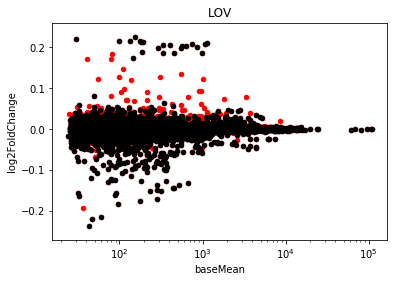

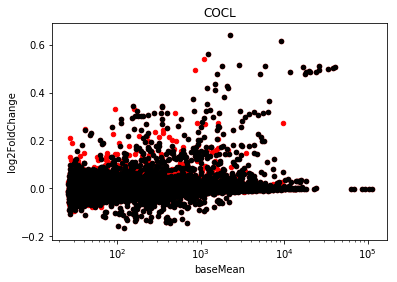

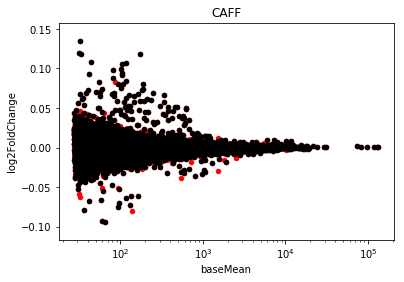

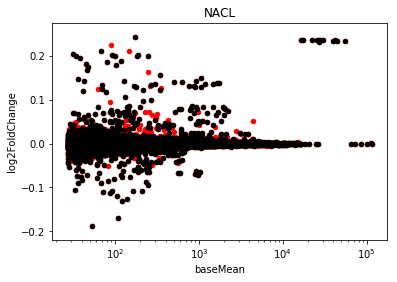

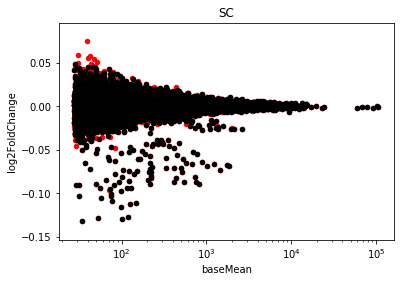

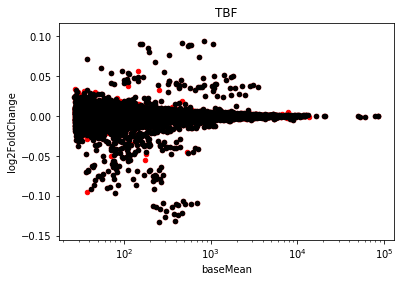

In [6]:
lova_filt = remove_outliers(lova, 'LOV')
cocl_filt = remove_outliers(cocl, 'COCL')
caff_filt = remove_outliers(caff,'CAFF')
nacl_filt = remove_outliers(nacl, 'NACL')
sc_filt = remove_outliers(sc, 'SC')
tbf_filt = remove_outliers(tbf, 'TBF')


In [7]:
lova_filt['condition'] = 'LOV'
cocl_filt['condition'] = 'COCL'
nacl_filt['condition'] = 'NACL'
sc_filt['condition'] = 'SC'
caff_filt['condition'] = 'CAFF'
tbf_filt['condition'] = 'TBF'


In [8]:
lova_inf = lova_filt.merge(oli_info, 'inner','barcode_id')
cocl_inf = cocl_filt.merge(oli_info, 'inner','barcode_id')
nacl_inf = nacl_filt.merge(oli_info, 'inner','barcode_id')
caff_inf = caff_filt.merge(oli_info, 'inner','barcode_id')
sc_inf = sc_filt.merge(oli_info, 'inner','barcode_id')

tbf_inf = tbf_filt.merge(oli_info, 'inner','barcode_id')

In [9]:
print(lova_inf['barcode_id'].nunique())
print(cocl_inf['barcode_id'].nunique())
print(nacl_inf['barcode_id'].nunique())
print(caff_inf['barcode_id'].nunique())
print(sc_inf['barcode_id'].nunique())

print(tbf_inf['barcode_id'].nunique())

3266
3280
3293
3385
3254
3151


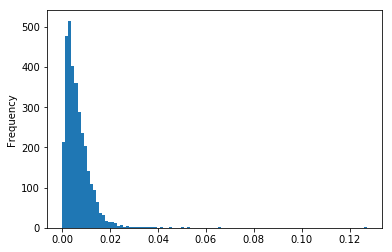

In [10]:
lova_inf.groupby('barcode_id')['log2FoldChange'].std().plot.hist(bins = 100)


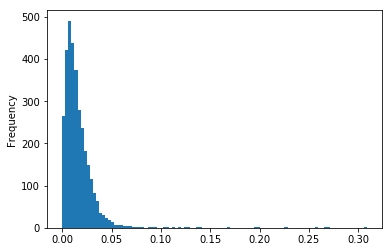

In [11]:
cocl_inf.groupby('barcode_id')['log2FoldChange'].std().plot.hist(bins = 100)

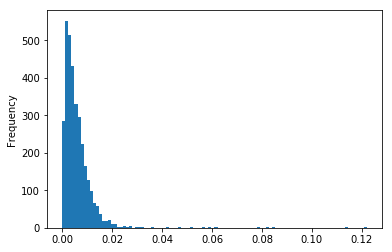

In [12]:
nacl_inf.groupby('barcode_id')['log2FoldChange'].std().plot.hist(bins = 100)

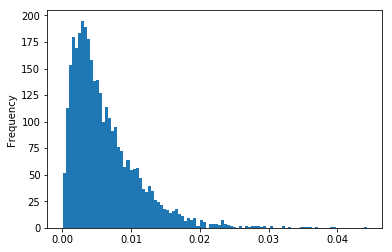

In [13]:
caff_inf.groupby('barcode_id')['log2FoldChange'].std().plot.hist(bins = 100)

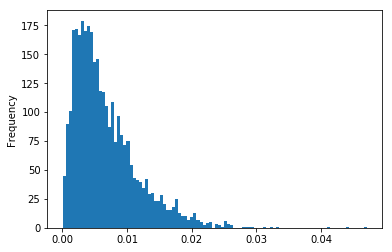

In [14]:
sc_inf.groupby('barcode_id')['log2FoldChange'].std().plot.hist(bins = 100)

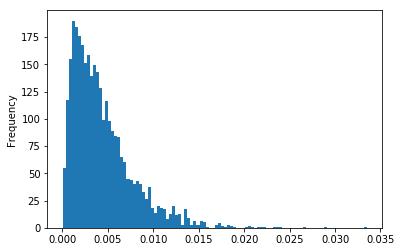

In [15]:
tbf_inf.groupby('barcode_id')['log2FoldChange'].std().plot.hist(bins = 100)

In [16]:
def bc_filter(df, cutoff):
    df_stds = df.groupby('barcode_id')['log2FoldChange'].std()
    good_bcs = df_stds[df_stds<cutoff].index
    return df[df['barcode_id'].isin(good_bcs)]

In [17]:
lova_inf =bc_filter(lova_inf,0.05)
cocl_inf = bc_filter(cocl_inf,0.05)
nacl_inf = bc_filter(nacl_inf,0.05)
caff_inf = bc_filter(caff_inf, 0.05)
sc_inf = bc_filter(sc_inf, 0.05)
tbf_inf = bc_filter(tbf_inf,0.05)

In [18]:
print(lova_inf['barcode_id'].nunique())
print(cocl_inf['barcode_id'].nunique())
print(nacl_inf['barcode_id'].nunique())
print(caff_inf['barcode_id'].nunique())
print(sc_inf['barcode_id'].nunique())
print(tbf_inf['barcode_id'].nunique())

3263
3208
3284
3385
3254
3151


In [19]:
all_data = pd.concat([lova_inf, sc_inf, tbf_inf,cocl_inf,nacl_inf,caff_inf])

Modeling neutral barcodes in CAFF


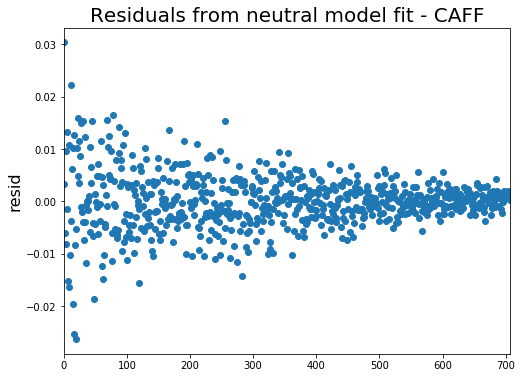

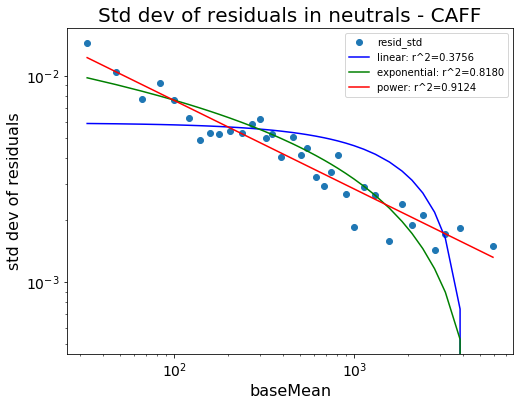

Selected model for CAFF: power
Formula: np.log(resid_std) ~ np.log(baseMean)


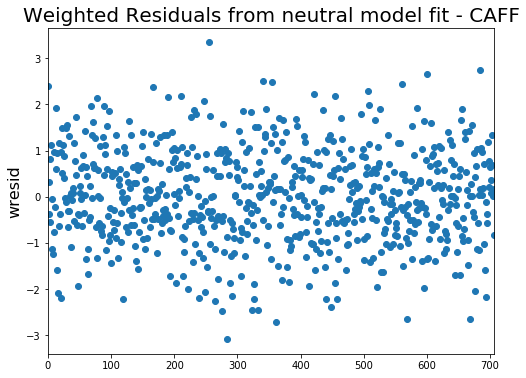

Modeling neutral barcodes in COCL


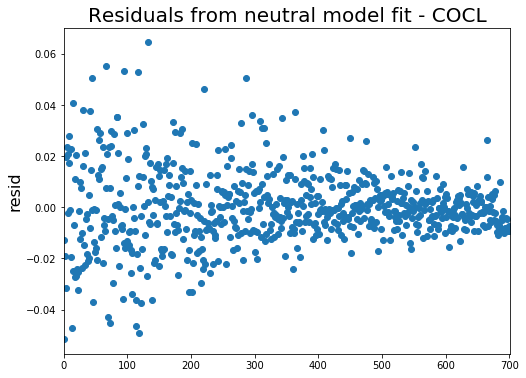

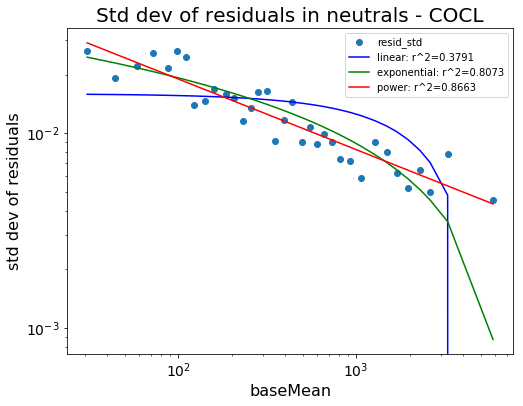

Selected model for COCL: power
Formula: np.log(resid_std) ~ np.log(baseMean)


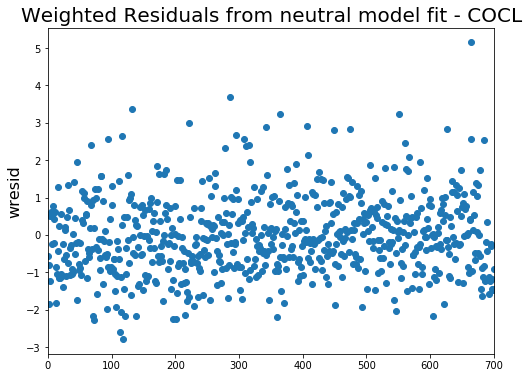

Modeling neutral barcodes in LOV


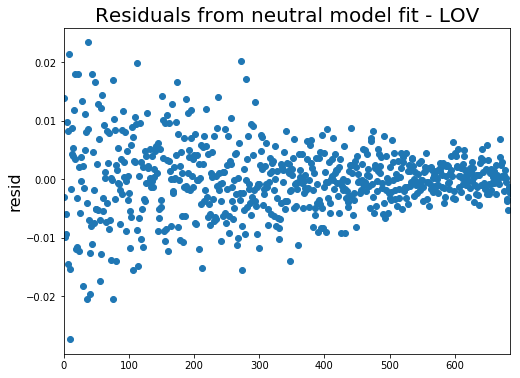

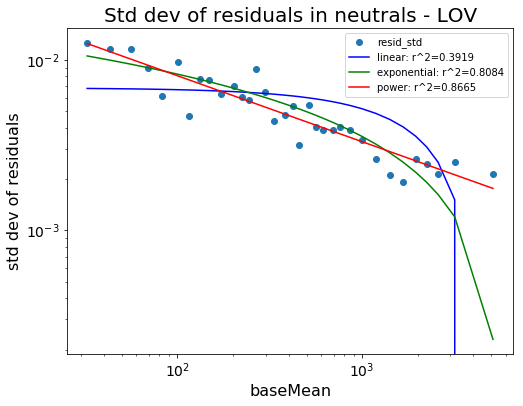

Selected model for LOV: power
Formula: np.log(resid_std) ~ np.log(baseMean)


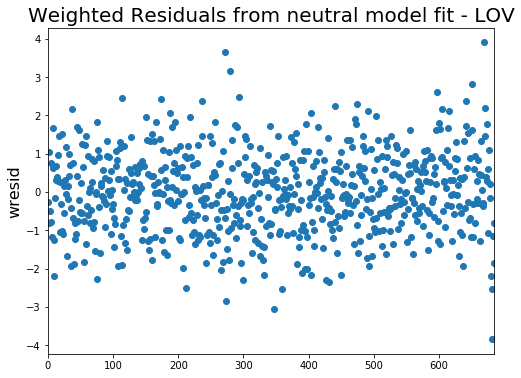

Modeling neutral barcodes in NACL


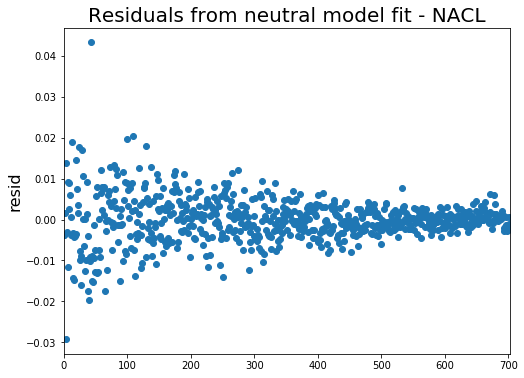

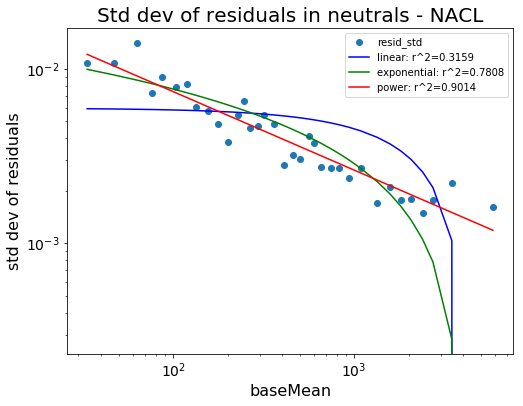

Selected model for NACL: power
Formula: np.log(resid_std) ~ np.log(baseMean)


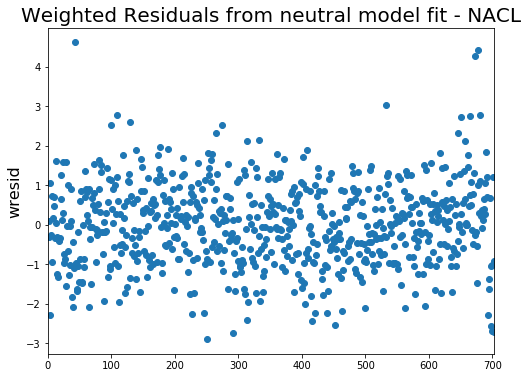

Modeling neutral barcodes in SC


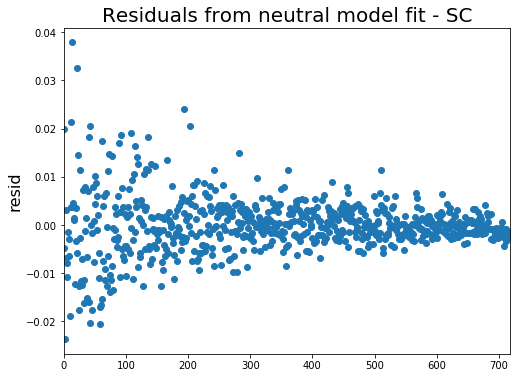

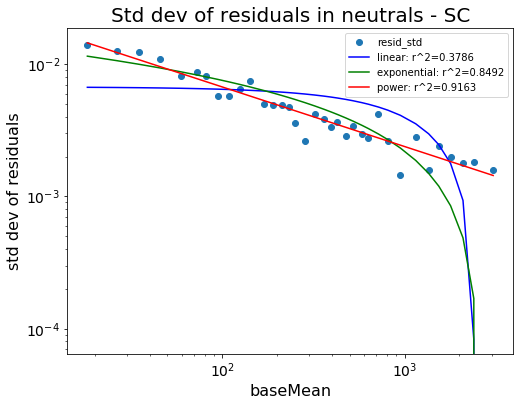

Selected model for SC: power
Formula: np.log(resid_std) ~ np.log(baseMean)


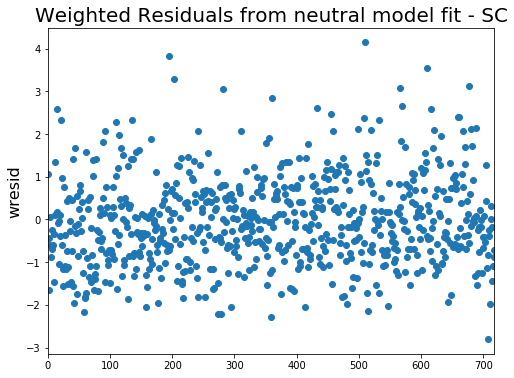

Modeling neutral barcodes in TBF


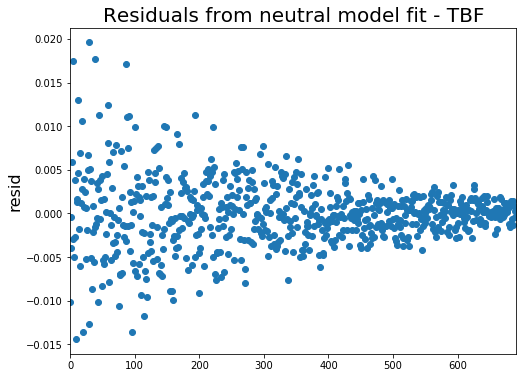

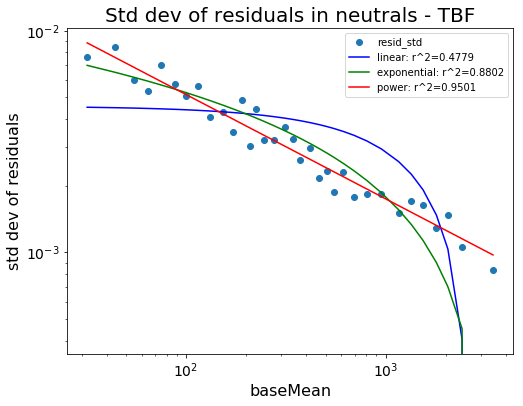

Selected model for TBF: power
Formula: np.log(resid_std) ~ np.log(baseMean)


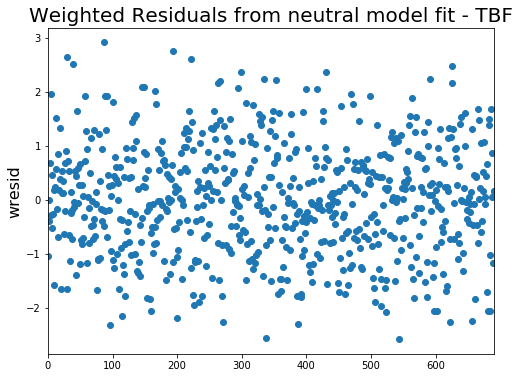

In [21]:
neutral_variance_model_dict = {}

for c, d_neutral in all_data[all_data['var_id'].str.startswith('neutral')].groupby('condition'):
    d_neutral = d_neutral.sort_values('baseMean').reset_index(drop=True)
    print('Modeling neutral barcodes in {}'.format(c))

    # fit OLS
    formula = 'log2FoldChange ~ np.log(baseMean)'
    neutral_model = ols(formula, d_neutral).fit()

    # plot residuals
    residuals = neutral_model.resid
    fig, ax = plt.subplots(figsize=(8,6))
    residuals.plot(ax=ax, marker='o', linestyle='')
    ax.set_ylabel('resid', fontsize=16)
    ax.set_title('Residuals from neutral model fit - {}'.format(c), fontsize=20)
    plt.show()

    # calculate standard deviations of residuals using rolling window of 20 barcodes
    window = 20
    residual_stds_df = pd.DataFrame.from_dict({'baseMean':d_neutral.sort_values('baseMean')['baseMean'].rolling(window).mean()[window-1::window],
                                               'resid_std':residuals.rolling(window).std()[window-1::window]})
    # find best fit for std deviation of residuals 
    fitted_models = {'linear' : ols(formula='resid_std ~ baseMean', data=residual_stds_df).fit(), 
                     'exponential' : ols(formula='resid_std ~ np.log(baseMean)', data=residual_stds_df).fit(), 
                     'power' : ols(formula='np.log(resid_std) ~ np.log(baseMean)', data=residual_stds_df).fit()}

    # plot std dev of residuals and fitted models
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot('baseMean', 'resid_std', data=residual_stds_df, marker='o', linestyle='')
    ax.plot(residual_stds_df['baseMean'], fitted_models['linear'].fittedvalues, 'b-', label='linear: r^2={:.4f}'.format(fitted_models['linear'].rsquared))
    ax.plot(residual_stds_df['baseMean'], fitted_models['exponential'].fittedvalues, 'g-', label='exponential: r^2={:.4f}'.format(fitted_models['exponential'].rsquared))
    ax.plot(residual_stds_df['baseMean'], np.exp(fitted_models['power'].fittedvalues), 'r-', label='power: r^2={:.4f}'.format(fitted_models['power'].rsquared))
    ax.set_xlabel('baseMean', fontsize=16)
    ax.set_ylabel('std dev of residuals', fontsize=16)
    ax.set_title('Std dev of residuals in neutrals - {}'.format(c), fontsize=20)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.show()

    # select model with best fit
    best_fit = max(fitted_models, key=lambda x: fitted_models[x].rsquared)
    print("Selected model for {}: {}".format(c, best_fit))
    std_model = fitted_models[best_fit]
    print("Formula:", std_model.model.formula)
#     display(std_model.summary())
    
    # calculate (inverse variance) weights based on fitted model, 
    if best_fit == "power":
        w = 1/np.exp(std_model.predict(d_neutral['baseMean']))**2
    else:
        w = 1/std_model.predict(d_neutral['baseMean'])**2

    # refit neutrals in WLS and inspect residuals
    formula = 'log2FoldChange ~ np.log(baseMean)'
    neutral_model = wls(formula, d_neutral, weights=w).fit()
    residuals = neutral_model.wresid[d_neutral.sort_values('baseMean').index]
    fig, ax = plt.subplots(figsize=(8,6))
    residuals.plot(ax=ax, marker='o', linestyle='')
    ax.set_ylabel('wresid', fontsize=16)
    ax.set_title('Weighted Residuals from neutral model fit - {}'.format(c), fontsize=20)
    plt.show()
    
    # store neutral model
    neutral_variance_model_dict[c] = (best_fit, std_model)

In [22]:
# prepare input data
d = all_data.copy()
d.loc[d['var_id'].str.startswith('neutral'), 'var_id'] = '.NEUTRAL' # sets neutral barcodes as reference

# calculate weights using neutral models
d['weight'] = 1
for g in d['condition'].unique():
    fit_type, neutral_model = neutral_variance_model_dict[g]
    if fit_type == "power":
        d.loc[d['condition']==g, 'weight'] = 1 / np.exp(neutral_model.predict(d.loc[d['condition']==g]))**2
    else:
        d.loc[d['condition']==g, 'weight'] = 1 / neutral_model.predict(d.loc[d['condition']==g])**2
        
# for each oligo not in neutral set, set its associated barcodes' weights to the median weight
median_weights = d.loc[d['var_id']!=".NEUTRAL"].groupby(['condition', 'barcode_id'])['weight'].median()
d.loc[d['var_id']!=".NEUTRAL", "weight"] = d.loc[d['var_id']!=".NEUTRAL"].apply(lambda x: median_weights.loc[(x.condition, x.barcode_id)], axis=1)


In [ ]:
# fit WLS
formula = 'z ~ C(var_id)+  C(condition)+ C(var_id):C(condition)'
wls_res_full= wls(formula, data=d, weights=d['weight']).fit()
# display(wls_res.summary())

# write WLS model summary table to file
file = open("./gxe_5comp_wls_summary_6repscm_fullmodel.txt", "w")
file.write(wls_res_full.summary().as_csv())
file.close()

In [47]:
wls_res_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      z   R-squared:                       0.961
Model:                            WLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     267.0
Date:                Wed, 16 Feb 2022   Prob (F-statistic):               0.00
Time:                        01:01:07   Log-Likelihood:            -1.5228e+05
No. Observations:              106527   AIC:                         3.225e+05
Df Residuals:                   97544   BIC:                         4.085e+05
Df Model:                        8982                                         
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                          0.0573      0.022      2.561      0.010       0.013       0.101
C(var_id)[T.EG8_00001]                            -0.0136      0.783     -0.017      0.986      -1.547       1.520
C(var_id)[T.EG8_00002]                             0.5562      0.435      1.279      0.201      -0.296       1.409
C(var_id)[T.EG8_00003]                             0.4517      0.355      1.272      0.204      -0.245       1.148
C(var_id)[T.EG8_00021]                            -0.1283      0.308     -0.417      0.677      -0.732       0.476
C(var_id)[T.EG8_00022]                             0.3400      0.329      1.035      0.301      -0.304       0.984
C(var_id)[T.EG8_00023]                             0.0670      0.226      0.296      0.767      -0.376       0.510
C(var_id)[T.EG8_00024]                            -0.4085      0.277     -1.475      0.140      -0.951       0.134
C(var_id)[T.EG8_00025]                             0.2372      0.257      0.922      0.356      -0.267       0.741
C(var_id)[T.EG8_00026]                             0.5606      0.190      2.954      0.003       0.189       0.933
C(var_id)[T.EG8_00027]                             0.2256      0.169      1.336      0.182      -0.105       0.557
C(var_id)[T.EG8_00028]                             0.1416      0.196      0.722      0.470      -0.243       0.526
C(var_id)[T.EG8_00029]                             0.0314      0.208      0.151      0.880      -0.376       0.439
C(var_id)[T.EG8_00030]                            -0.2087      0.204     -1.022      0.307      -0.609       0.192
C(var_id)[T.EG8_00031]                            -0.1953      0.224     -0.873      0.382      -0.633       0.243
C(var_id)[T.EG8_00036]                             0.4450      0.722      0.616      0.538      -0.970       1.860
C(var_id)[T.EG8_00038]                            -0.0163      0.199     -0.082      0.935      -0.405       0.373
C(var_id)[T.EG8_00040]                            -0.7083      0.975     -0.726      0.468      -2.620       1.203
C(var_id)[T.EG8_00054]                             0.0108      0.983      0.011      0.991      -1.915       1.937
C(var_id)[T.EG8_00055]                            15.1718      0.435     34.881      0.000      14.319      16.024
C(var_id)[T.EG8_00079]                             0.7474      0.163      4.579      0.000       0.427       1.067
C(var_id)[T.EG8_00080]                             0.4830      0.159      3.039      0.002       0.171       0.795
C(var_id)[T.EG8_00081]                             0.6927      0.188      3.694      0.000       0.325       1.060
C(var_id)[T.EG8_00093]                             0.0172      0.152      0.113      0.910   

In [ ]:
(.783-0.157)

In [ ]:
1-.783

In [ ]:
(.957-0.678)/.957

In [27]:
var_dict = dict(d[d['var_id']!= '.NEUTRAL'].groupby('var_id').apply(lambda x: list(x.condition.unique())) )
var_fitness_df = pd.concat([calc_var_fitness(var, wls_res_full_hits, cond_list) for var, cond_list in var_dict.items()], join='inner', axis=0)

# adjust formatting
var_fitness_df.index = pd.MultiIndex.from_tuples(var_fitness_df.index.str.split(',').tolist(), names=['var_id', 'condition'])
var_fitness_df = var_fitness_df.reset_index()
# calc padj
var_fitness_df = var_fitness_df.rename(columns={'P>|t|': 'pval'})
var_fitness_df['padj'] = multipletests(var_fitness_df['pval'], alpha=0.05, method='fdr_bh')[1]
display(var_fitness_df.sort_values('padj'))

var_fitness_df.to_csv('../data_tables/Fitness_files/new_ergosterol_fitness.tsv',sep = '\t')

var_id condition          coef   std err            t      pval  \
8555     hdr_20      NACL  4.641749e-02  0.000968    47.968183  0.000000   
8562     hdr_21        SC -8.227736e-02  0.001925   -42.733973  0.000000   
8629     hdr_34      COCL  1.775736e-01  0.002537    69.998514  0.000000   
8569     hdr_22       TBF  4.234287e-02  0.001108    38.205980  0.000000   
8513     hdr_14      NACL -1.130542e-01  0.002029   -55.726494  0.000000   
8491     hdr_10        SC -6.879089e-02  0.000841   -81.808994  0.000000   
1909  EGD_00012       TBF  3.207583e-02  0.000412    77.832398  0.000000   
211   EG8_00128       TBF -4.321900e-02  0.000935   -46.231463  0.000000   
8527     hdr_16       TBF -1.178995e-01  0.000862  -136.789800  0.000000   
8647     hdr_37      COCL  3.062689e-01  0.001911   160.231418  0.000000   
8559     hdr_21      COCL  4.935639e-01  0.000927   532.372696  0.000000   
8526     hdr_16        SC -2.568256e-02  0.000659   -38.968391  0.000000   
3991  ERG_00445       TBF -7.845646e-02  0.001455   -53.915900  0.000000   
209   EG8_00128      NACL -6.738604e-02  0.001145   -58.866232  0.000000   
8489     hdr_10       LOV  2.897915e-02  0.000756    38.341104  0.000000   
7631  ERG_02317        SC -8.898288e-02  0.001401   -63.534567  0.000000   
8614     hdr_30       LOV -9.280804e-02  0.002280   -40.698030  0.000000   
8701      hdr_7      COCL  1.357484e-01  0.003006    45.159651  0.000000   
8625     hdr_33       LOV  2.115423e-01  0.002452    86.283604  0.000000   
3985  ERG_00444       TBF -1.003943e-01  0.001044   -96.128673  0.000000   
8633     hdr_34       TBF  4.863029e-02  0.000642    75.754766  0.000000   
8695      hdr_6      COCL  1.641506e-01  0.003362    48.828002  0.000000   
6163  ERG_01532       LOV -5.804886e-02  0.001364   -42.569335  0.000000   
8525     hdr_16      NACL  2.344545e-01  0.000213  1101.206949  0.000000   
8524     hdr_16       LOV -1.456851e-01  0.001616   -90.169513  0.000000   
3853  ERG_00388       TBF -6.902375e-02  0.001500   -46.011767  0.000000   
2014  EGD_00086       LOV -4.439823e-02  0.000955   -46.485171  0.000000   
3871  ERG_00397       TBF  3.661809e-02  0.000540    67.815427  0.000000   
8514     hdr_14        SC -9.575943e-02  0.002047   -46.774964  0.000000   
8626     hdr_33      NACL  1.822075e-01  0.003131    58.193995  0.000000   
...         ...       ...           ...       ...          ...       ...   
798   EG9_00123       LOV -1.090728e-05  0.003373    -0.003234  0.997420   
4312  ERG_00644      NACL -2.667020e-06  0.001599    -0.001667  0.998670   
8859  noncut_33      CAFF  9.954409e-06  0.002515     0.003958  0.996842   
1854  EGC_00221      NACL  1.647324e-06  0.001751     0.000941  0.999250   
8744  noncut_15       LOV -1.066947e-05  0.003529    -0.003024  0.997588   
6315  ERG_01641       LOV -3.257052e-06  0.001758    -0.001853  0.998522   
6375  ERG_01664        SC -5.587264e-06  0.001594    -0.003504  0.997204   
2025  EGD_00096      COCL -7.918538e-06  0.010889    -0.000727  0.999420   
5301  ERG_01093        SC  1.195311e-05  0.002704     0.004421  0.996473   
3749  ERG_00316        SC  7.214556e-06  0.003398     0.002123  0.998306   
5258  ERG_01074      NACL  9.222268e-06  0.002230     0.004136  0.996700   
6952  ERG_01927       LOV  9.701494e-06  0.001831     0.005299  0.995772   
3080  ERG_00031       LOV -3.782037e-06  0.000979    -0.003865  0.996916   
4817  ERG_00824      CAFF -7.032664e-07  0.000754    -0.000933  0.999256   
874   EG9_00179        SC -1.269278e-05  0.005032    -0.002522  0.997987   
940   EG9_00225        SC -1.596424e-05  0.004079    -0.003914  0.996877   
5012  ERG_00904      NACL -4.563483e-06  0.002099    -0.002174  0.998265   
566   EG8_00389      COCL  5.115140e-06  0.003339     0.001532  0.998778   
4701  ERG_00799        SC -4.530550e-06  0.001894    -0.002392  0.998091   
365   EG8_00245       TBF  6.589910e-06  0.001465     0.004498  0.996411   
2915  EGE_00390        SC -1.554933e-05  0.006792    -0.0

In [ ]:
var_dict = dict(d[d['var_id']!= '.NEUTRAL'].groupby('var_id').apply(lambda x: list(x.condition.unique())) )
gxe_df = pd.concat([calc_cond_interactions(var, wls_res_full_hits, cond_list) for var, cond_list in var_dict.items() if len(cond_list)>=2], join='inner', axis=0)

# # adjust formatting
gxe_df.index = pd.MultiIndex.from_tuples(gxe_df.index.str.split(':').tolist(), names=['var_id', 'gxe'])


In [ ]:
gxe_df = gxe_df.reset_index()
# calc padj
gxe_df = gxe_df.rename(columns={'P>|t|': 'pval'})
gxe_df['padj'] = multipletests(gxe_df['pval'], alpha=0.1, method='fdr_bh')[1]
display(gxe_df.sort_values('padj'))
gxe_df.to_csv('../data_tables/new_ergosterol_interactions.tsv',sep = '\t')
